In [10]:
import os
import zipfile
from zenodo_get import zenodo_get

# Create local directory for the netCDF files, if it doesn't already exist

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir,r'20210205_LinkingIntrinsicAndApparentRelationships')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# Download the zip file from the Zenodo repository

zenodo_get(['-d','10.5281/zenodo.4511337'])

# Extract the contents (netCDF files) of the zip file to the local directory

with zipfile.ZipFile("20210205_LinkingIntrinsicAndApparentRelationships.zip","r") as zip_ref:
    zip_ref.extractall("20210205_LinkingIntrinsicAndApparentRelationships")
    
import math
import netCDF4 as nc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Specify current directory and directory with data files

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir,r'20210205_LinkingIntrinsicAndApparentRelationships')
    
# Name of the Scenario 1 netCDF Source File
    
s1_source_file = 'Scenario1SourceFile.nc'

# Assign the data to the proper variable and assign names; most of the
# variables have latitude, longitude, month, and depth; for Scenario 1
# we are just using the surface values where depth=1

data = nc.Dataset(os.path.join(data_dir,s1_source_file))

lat = data['GEOLAT_T'][:]
lon = data['GEOLON_T'][:]
time_initial = data['TIME'][:]

po4 = data['PO4'][:]
po4 = np.squeeze(po4)

fed = data['FED'][:]
fed = np.squeeze(fed)

irr_mix = data['IRR_MIX'][:]
irr_mix = np.squeeze(irr_mix)

# Calculate the limitation terms based on the inputs from phosphate, iron, and light

phoslim = po4/(1e-7+po4)
ironlim = fed/(2e-10+fed)
lightlim = irr_mix/(34.3+irr_mix)

# Initialize the biomass matrix and then calculate the biomass

bio = np.empty((12,80,120))*np.nan

pstar = 1.9e-6 # Scaling constant

for i in range(12):
    for j in range(80):
        for k in range(120):
            if phoslim[i,j,k] < ironlim[i,j,k]:
                bio[i,j,k] = pstar*phoslim[i,j,k]*lightlim[i,j,k]
            elif ironlim[i,j,k] < phoslim[i,j,k]:
                bio[i,j,k] = pstar*ironlim[i,j,k]*lightlim[i,j,k]
                
# Create lists for the variable names and their respective units

variables = ['Index','Latitude','Longitude','Month','Macronutrient','Micronutrient','Irradiance','Biomass']
units = ['','degrees E','degrees N','','mol/kg','mol/kg','W/m2','mol/kg']

# Give a unique index number to each lat/lon pair and reshape it into a 120x80 array

index_matrix = range(1,9601)
index_matrix = np.reshape(index_matrix,(120,80))

# Initialize the array that will contain all of the combined data

final = np.empty((120*80*12,8))*np.nan

# Move the values from each variable into a column corresponding to the correct
# latitude, longitude, and month; this creates a matrix where each column corresponds
# to a variable and each row corresponds to an observation

for i in range(12):
    for j in range(80):
        for k in range(120):
            index_number = index_matrix[k,j]
            final[index_number+((i-1)*9600),0] = index_number + ((i-1)*9600)
            final[index_number+((i-1)*9600),1] = lat[j,k]
            final[index_number+((i-1)*9600),2] = lon[j,k]
            final[index_number+((i-1)*9600),3] = time_initial[i]
            final[index_number+((i-1)*9600),4] = po4[i,j,k]
            final[index_number+((i-1)*9600),5] = fed[i,j,k]
            final[index_number+((i-1)*9600),6] = irr_mix[i,j,k]
            final[index_number+((i-1)*9600),7] = bio[i,j,k]
            
# Get rid of any rows that have NaN (not-a-number) values

final = final[~np.isnan(final).any(axis=1),:]

# Turn the numpy array into a dataframe with the columns have labels corresponding to
# the variable names

final = pd.DataFrame(final,columns=variables)

Title: Dataset and scripts for manuscript "Can machine learning extract the mechanisms controlling phytoplankton growth from large-scale observations? – A proof of concept study"
Keywords: 
Publication date: 2020-07-07
DOI: 10.5281/zenodo.4511337
Total size: 389.7 MB

Link: https://zenodo.org/api/files/5e9b5bba-18ce-448f-9e43-fc62a09f6edb/20210205_LinkingIntrinsicAndApparentRelationships.zip   size: 389.7 MB
20210205_LinkingIntrinsicAndApparentRelationships.zip is already downloaded correctly.
All files have been downloaded.
C:\Users\holde\AppData\Local\Temp\ipykernel_13148\1986519742.py:103: UserWarning: Warning: converting a masked element to nan.
  final[index_number+((i-1)*9600),4] = po4[i,j,k]
C:\Users\holde\AppData\Local\Temp\ipykernel_13148\1986519742.py:104: UserWarning: Warning: converting a masked element to nan.
  final[index_number+((i-1)*9600),5] = fed[i,j,k]
C:\Users\holde\AppData\Local\Temp\ipykernel_13148\1986519742.py:105: UserWarning: Warning: converting a masked elem

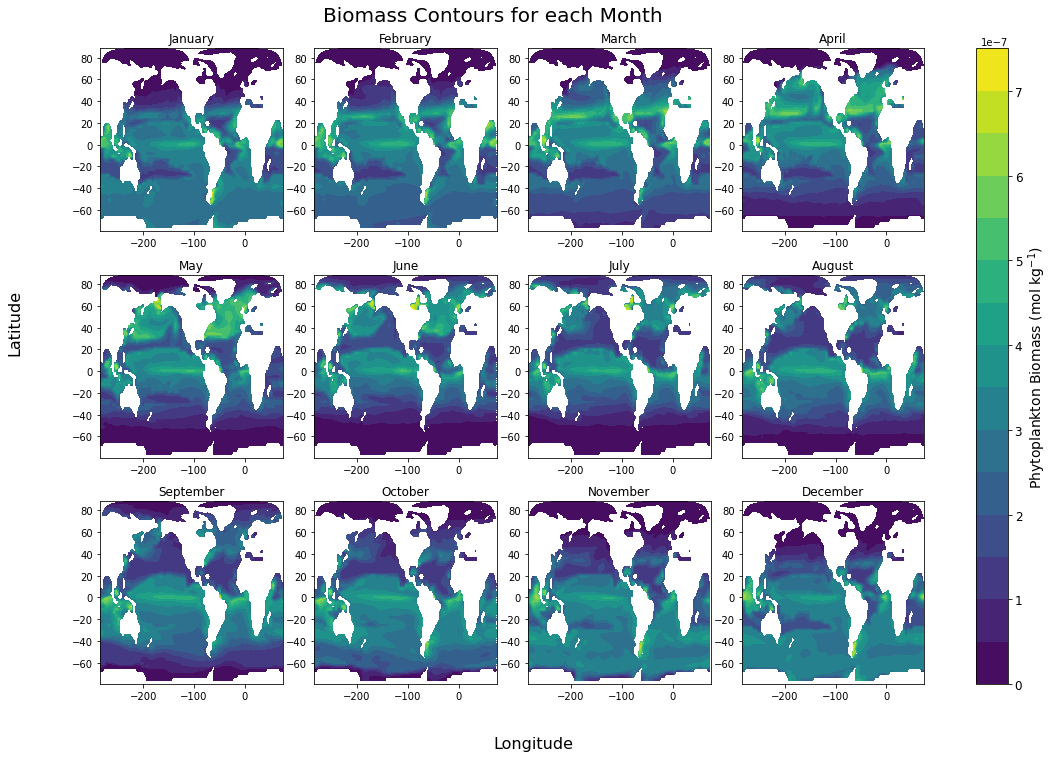

In [11]:
# Contours for phytoplankton biomass

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.nanmax(bio)
fmin = np.nanmin(bio)
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Biomass Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,bio[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,bio[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Phytoplankton Biomass (mol kg$^{-1}$)',fontsize=14)
plt.show()

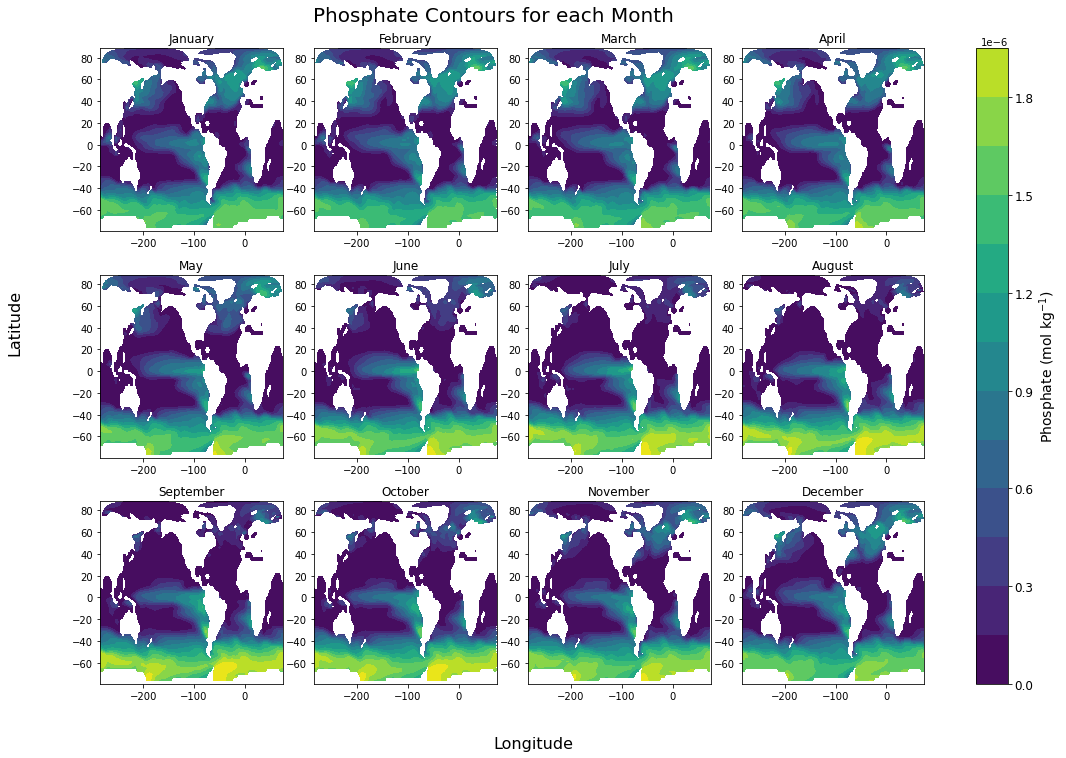

In [12]:
# Contours for phosphate

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.nanmax(po4)
fmin = np.nanmin(po4)
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Phosphate Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,po4[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,po4[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Phosphate (mol kg$^{-1}$)',fontsize=14)
plt.show()

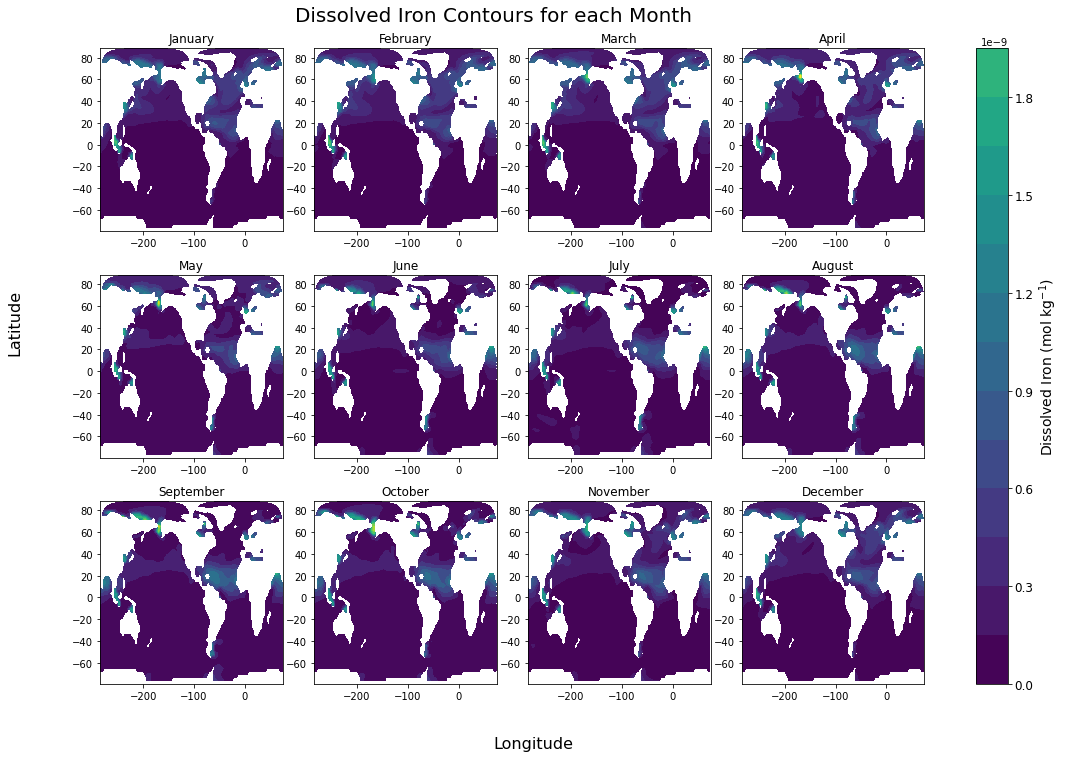

In [13]:
# Contours for dissolved iron

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.nanmax(fed)
fmin = np.nanmin(fed)
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Dissolved Iron Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,fed[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,fed[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Dissolved Iron (mol kg$^{-1}$)',fontsize=14)
plt.show()

C:\Users\holde\AppData\Local\Temp\ipykernel_13148\3389558678.py:14: RuntimeWarning: invalid value encountered in log10
  axs[i,j].contourf(lon,lat,np.log10(fed[4*i+j,:,:]),vmin=fmin,vmax=fmax,levels=15)
C:\Users\holde\AppData\Local\Temp\ipykernel_13148\3389558678.py:18: RuntimeWarning: invalid value encountered in log10
  cbar = plt.colorbar(axs[2,3].contourf(lon,lat,np.log10(fed[4*i+j,:,:]),vmin=fmin,vmax=fmax,levels=15),ax=axs)


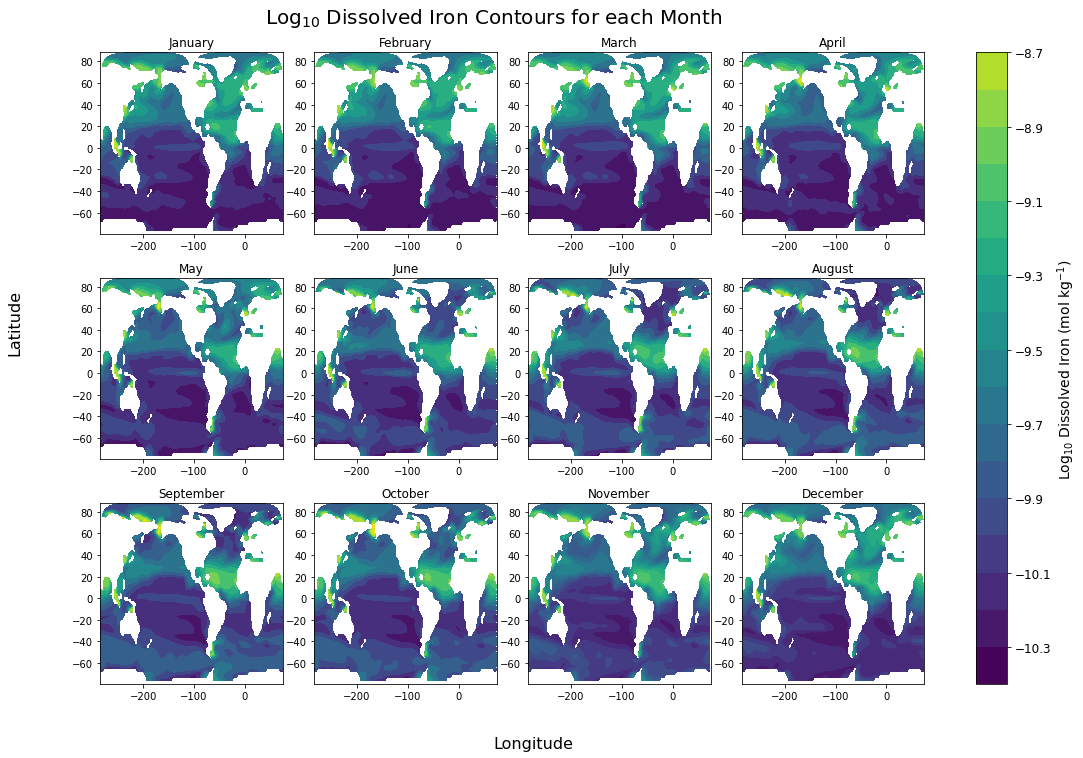

In [14]:
# Contours for dissolved iron (log10 transformed)

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.log10(np.nanmax(fed))
fmin = np.log10(np.nanmin(fed))
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Log$_{10}$ Dissolved Iron Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,np.log10(fed[4*i+j,:,:]),vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,np.log10(fed[4*i+j,:,:]),vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Log$_{10}$ Dissolved Iron (mol kg$^{-1}$)',fontsize=14)
plt.show()

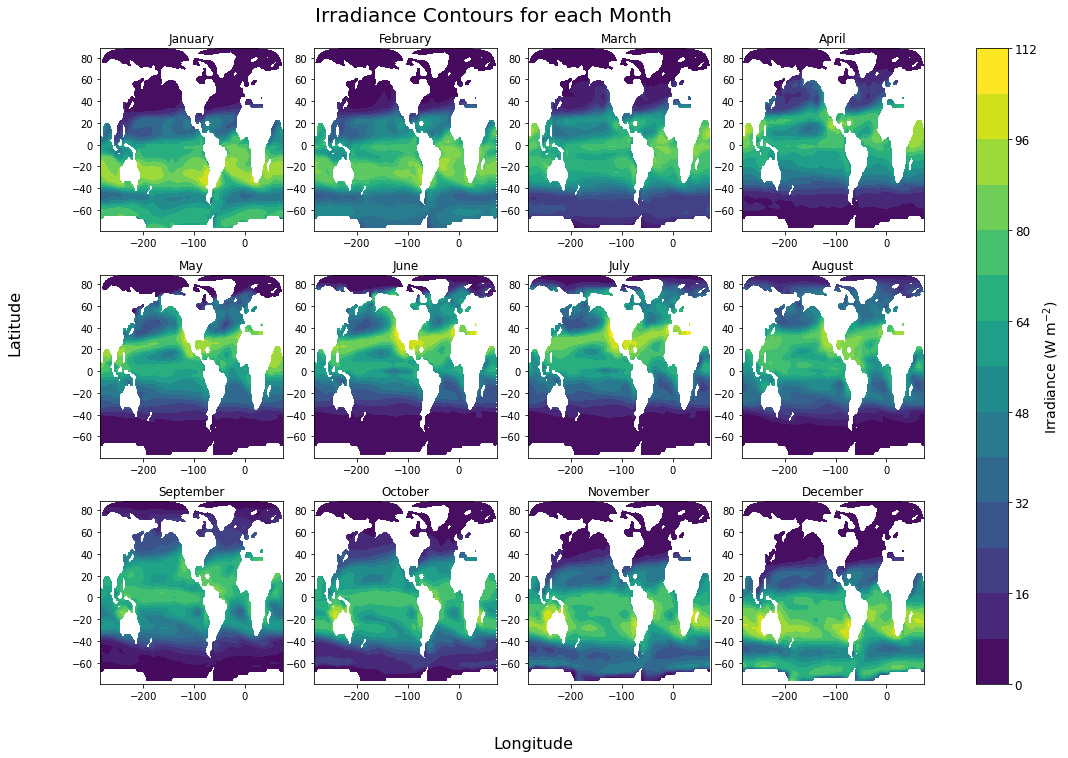

In [15]:
# Contours for irradiance

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.nanmax(irr_mix)
fmin = np.nanmin(irr_mix)
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Irradiance Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,irr_mix[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,irr_mix[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Irradiance (W m$^{-2}$)',fontsize=14)
plt.show()

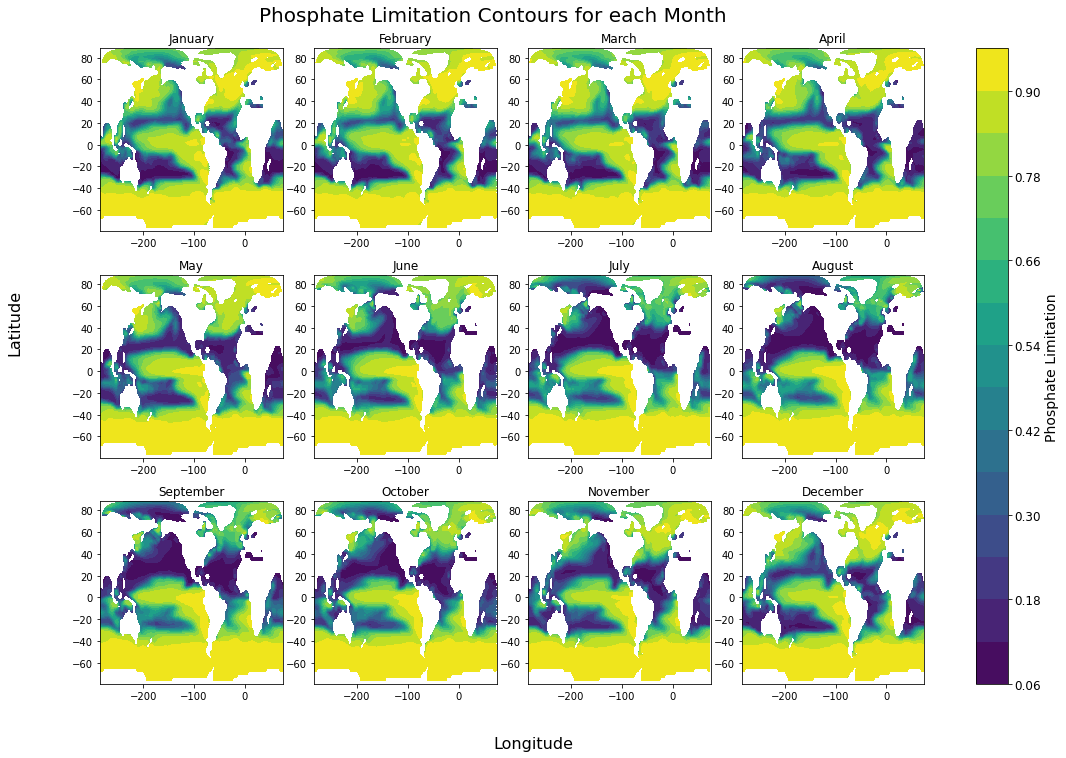

In [16]:
# Contours for phosphate limitation

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.nanmax(phoslim)
fmin = np.nanmin(phoslim)
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Phosphate Limitation Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,phoslim[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,phoslim[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Phosphate Limitation',fontsize=14)
plt.show()

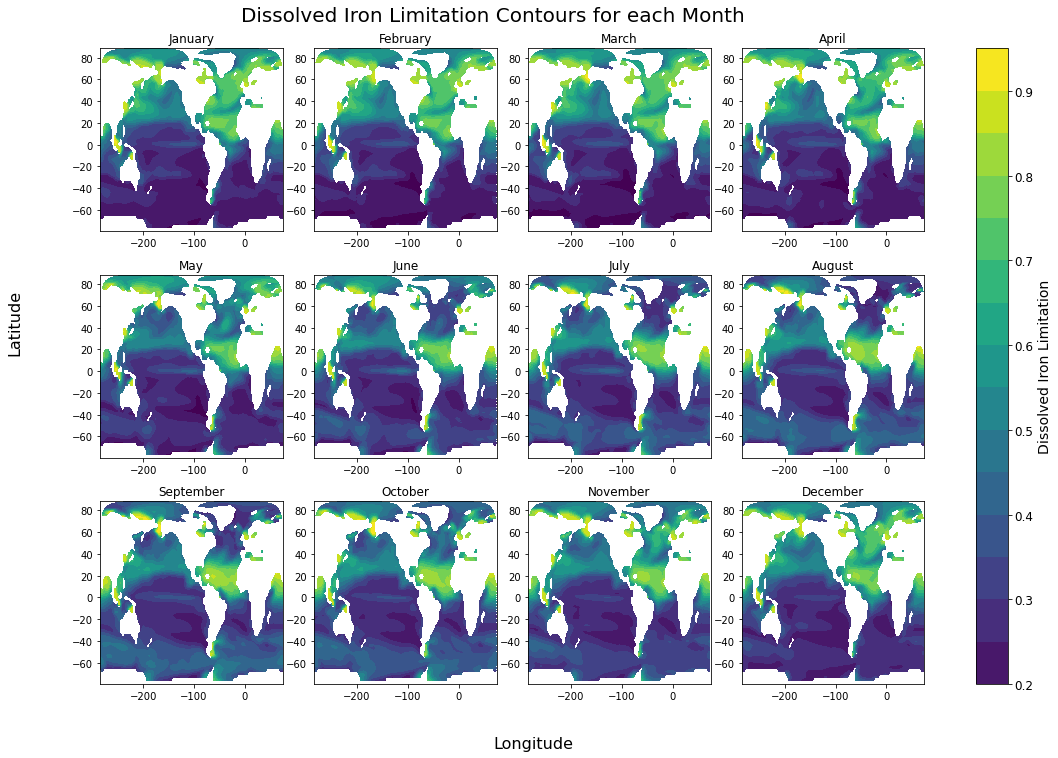

In [18]:
# Contours for dissolved iron limitation

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.nanmax(ironlim)
fmin = np.nanmin(ironlim)
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Dissolved Iron Limitation Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,ironlim[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,ironlim[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Dissolved Iron Limitation',fontsize=14)
plt.show()

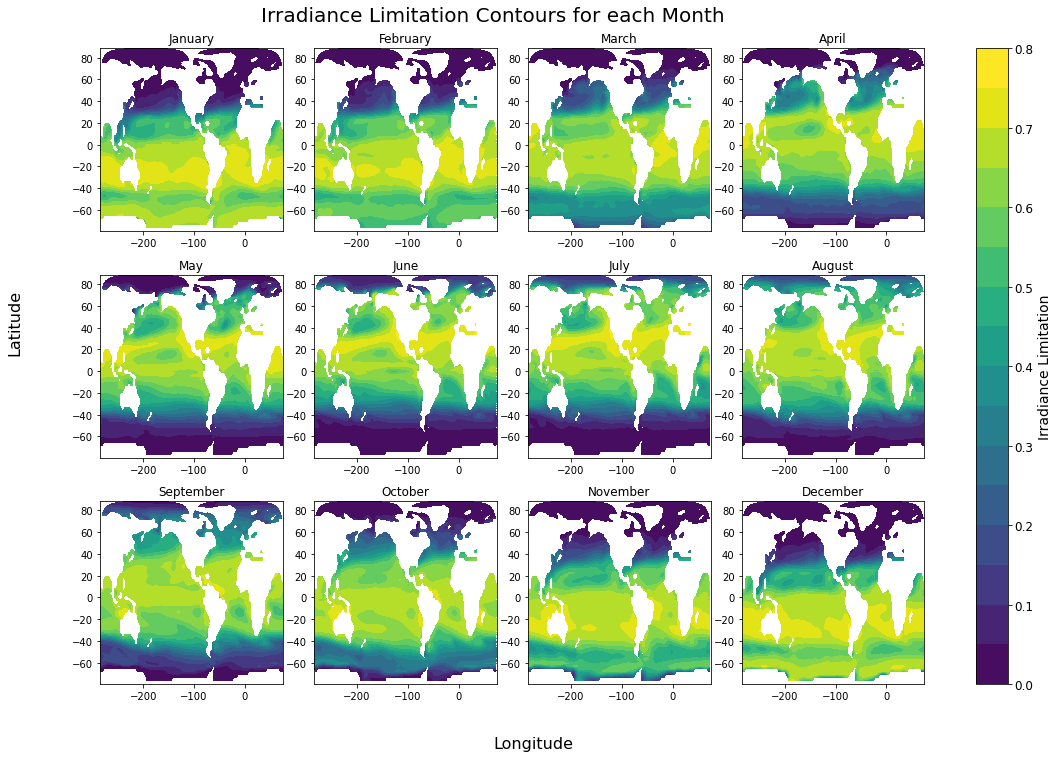

In [19]:
# Contours for irradiance limitation

months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
fmax = np.nanmax(lightlim)
fmin = np.nanmin(lightlim)
fig, axs = plt.subplots(3,4,figsize=(15,10))
fig.suptitle('Irradiance Limitation Contours for each Month',fontsize=20,x=0.4)
fig.text(0.4,-0.05,'Longitude',fontsize=16)
fig.text(-0.05,0.5,'Latitude',rotation='vertical',fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i,j].contourf(lon,lat,lightlim[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15)
        axs[i,j].set_title(months[4*i+j])
        
plt.tight_layout()
cbar = plt.colorbar(axs[2,3].contourf(lon,lat,lightlim[4*i+j,:,:],vmin=fmin,vmax=fmax,levels=15),ax=axs)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Irradiance Limitation',fontsize=14)
plt.show()

In [20]:
final.describe()

,Index,Latitude,Longitude,Month,Macronutrient,Micronutrient,Irradiance,Biomass
count,77328.000000,77328.000000,77328.000000,77328.000000,7.732800e+04,7.732800e+04,77328.000000,7.732800e+04
mean,47892.493482,-6.136914,-108.760219,6.500000,6.209836e-07,1.893364e-10,38.500483,2.247178e-07
std,33241.381339,43.756329,97.842469,3.452075,5.758578e-07,2.315959e-10,28.414227,1.365318e-07
min,-9595.000000,-76.509430,-283.500000,1.000000,6.487116e-09,4.274880e-11,0.000000,0.000000e+00
25%,19195.500000,-45.670570,-187.500000,3.750000,6.118881e-08,7.521412e-11,8.468001,1.195597e-07
50%,47986.000000,-6.072007,-118.500000,6.500000,4.737432e-07,1.047536e-10,39.662863,2.296902e-07
75%,76776.500000,25.451685,-25.500000,9.250000,1.079199e-06,1.895132e-10,64.402811,3.261843e-07
max,105567.000000,88.371864,73.500000,12.000000,2.092362e-06,2.869619e-09,107.836105,7.430630e-07


In [21]:
final.corr()

,Index,Latitude,Longitude,Month,Macronutrient,Micronutrient,Irradiance,Biomass
Index,1.000000,1.448117e-03,7.795831e-02,9.969477e-01,0.006349,0.001319,-0.013996,0.008313
Latitude,0.001448,1.000000e+00,1.220583e-02,-4.601273e-16,-0.596004,0.447199,-0.023911,0.012837
Longitude,0.077958,1.220583e-02,1.000000e+00,-6.800117e-16,0.089602,0.035460,-0.032935,-0.086776
Month,0.996948,-4.601273e-16,-6.800117e-16,1.000000e+00,-0.000273,-0.001814,-0.011524,0.015050
Macronutrient,0.006349,-5.960042e-01,8.960151e-02,-2.732594e-04,1.000000,-0.199261,-0.460621,-0.285008
Micronutrient,0.001319,4.471994e-01,3.545962e-02,-1.814026e-03,-0.199261,1.000000,-0.126018,-0.131225
Irradiance,-0.013996,-2.391055e-02,-3.293540e-02,-1.152423e-02,-0.460621,-0.126018,1.000000,0.639939
Biomass,0.008313,1.283721e-02,-8.677614e-02,1.504998e-02,-0.285008,-0.131225,0.639939,1.000000


<AxesSubplot:>

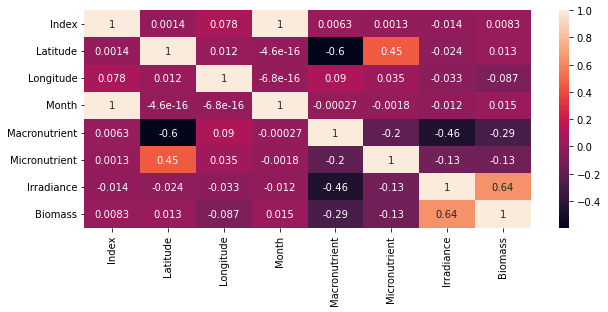

In [22]:
plt.figure(figsize=(10,4))
sns.heatmap(final.corr(),annot=True)

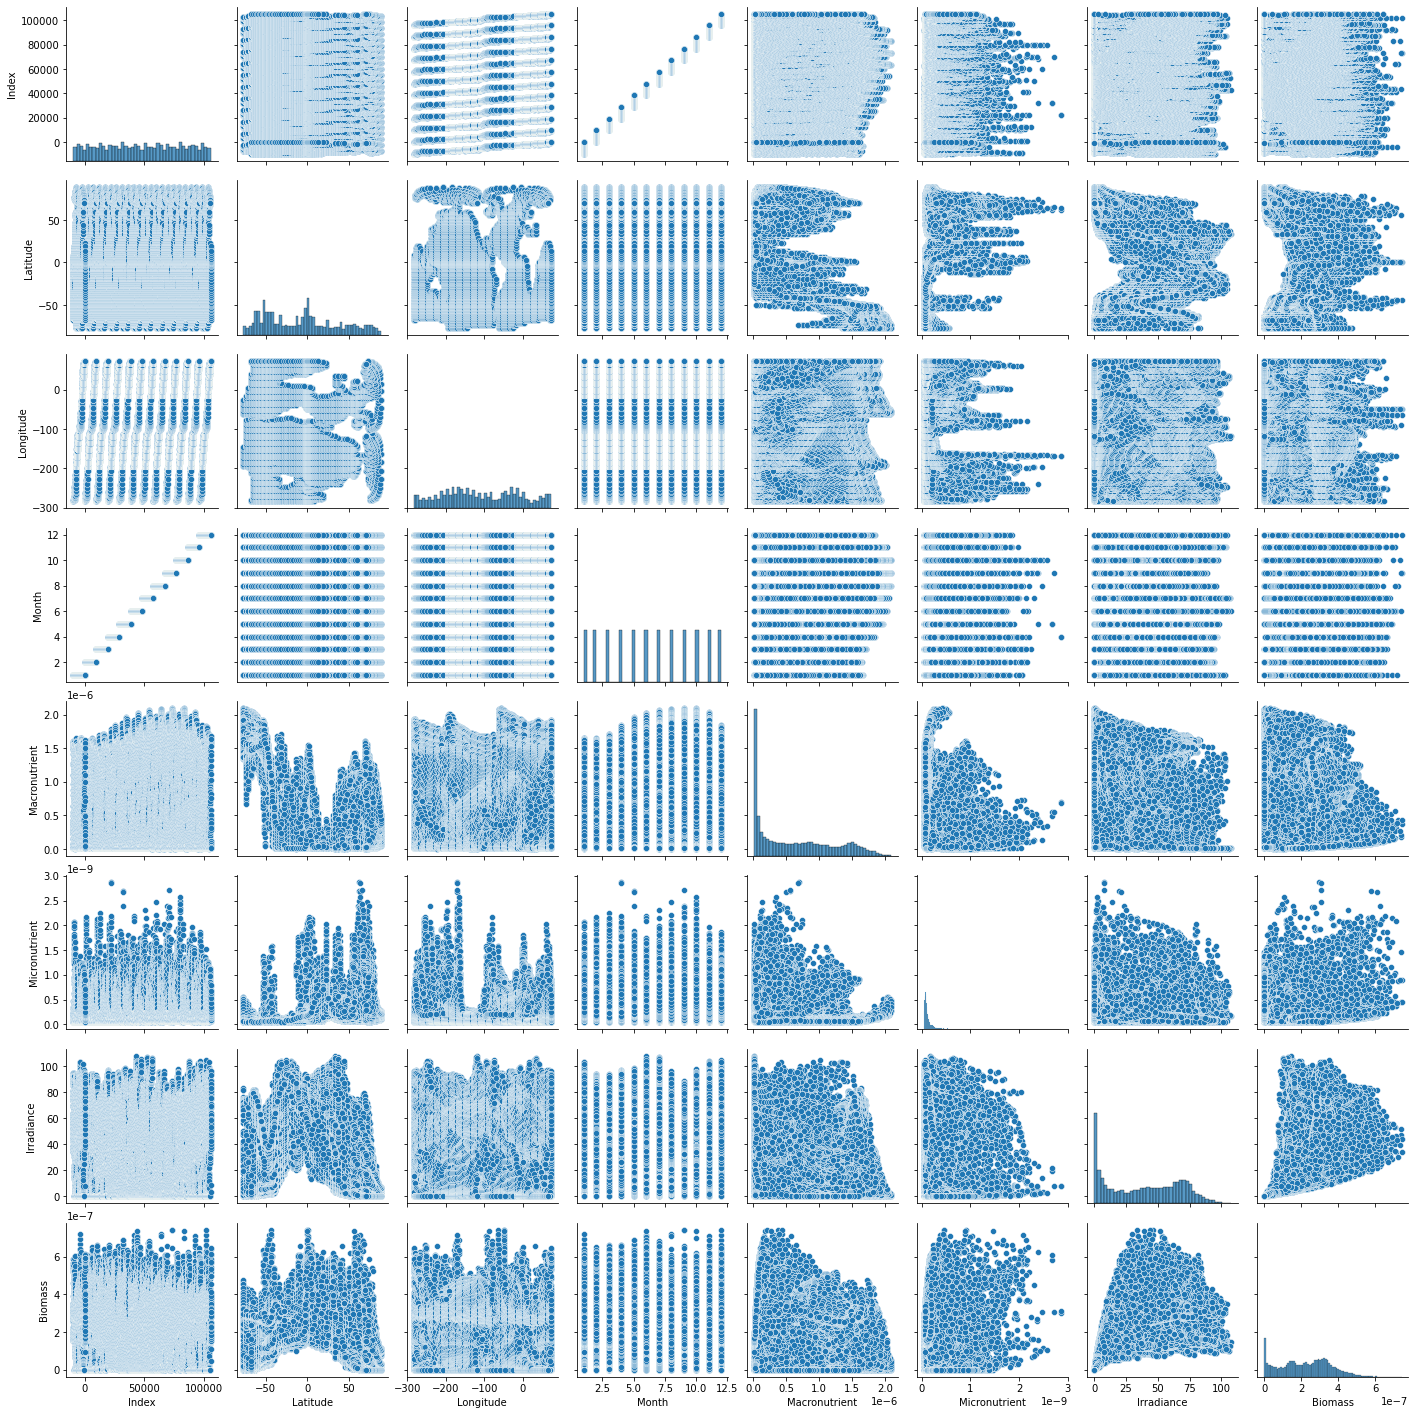

In [23]:
sns.pairplot(final)